## Import packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

## Example 1: Supervised classification with KNN

In this example, we will use KNN to classify flowers from Iris dataset.
* The dataset consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). 
* Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

**Load the dataset**

We can download the Iris dataset in the form of a Pandas ``DataFrame`` using the [seaborn](http://seaborn.pydata.org/) library. The dataset contains a set of 150 records under five attributes - sepal length, sepal width, petal length, petal width and species.

The first five rows: 
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa 

Summary statistics: 
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000 

Missing values: 
sepal_length

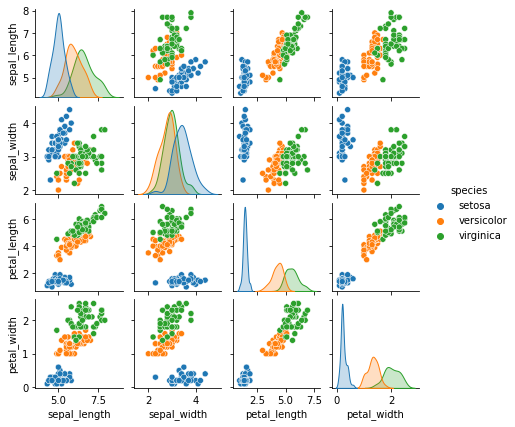

In [2]:
# Load the dataframe
df = sns.load_dataset('iris')

# Let's get more familiar with our data
print(f'The first five rows: \n{df.head()} \n')
print(f'Summary statistics: \n{df.describe()} \n')
print(f'Missing values: \n{df.isnull().sum()} \n')

# Let's visualize our data
sns.pairplot(df, hue='species', height=1.5);

### Train KNN classifier

We will build a KNN classifier using the following procedure:

* Split the data into training (70%), validation (20%), and testing (10%) sets.
  * Random state of 100 is used for repeatability.
  * Stratified random samling is applied by specifiying the `stratify` parameter. Stratified random samling maintains the proportions of each of three species of Iris the same in each set (training/validation/testing).
  * Our dataset is perfectly balanced (50 observations for each category), so we can simply use accuracy as our performance metric.
  
* Each set is required for the following reasons:
  * Train set will be used to train our model. Our dataset consists of only 150 samples, so it is important to make our training set as large as possible.
  * Validation set will be used to tune our parameters. KNN has only one tunning parameter, which is the number of neighbours (K). We will plot K (1-15) against accuracy scores and choose the best K.
  * The test set will only be used to evaluate performance of the final model.

* Before we train our models, we will normalize each set on the training set's mean and standard deviation.
  * Do not preprocess your training set using validation or/and test sets. If you do so, your model will have some idea about your validation/test sets' distributions while training (this is called data leakage).
  * Also, remeber to apply the same transformations to your validation/test sets as you do to your train set (use the train set's mean and standard deviation).

Shape of X_train (105, 4), Shape of y_train (105,)
Shape of X_val (30, 4), Shape of y_val (30,)
Shape of X_test (15, 4), Shape of y_test (15,)


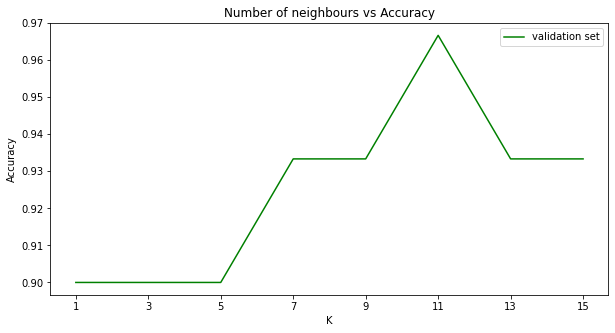

In [3]:
# Let's split our entire dataset into train and val/test sets
X_train, X_valtest, y_train, y_valtest = train_test_split(
    df.iloc[:,0:4], df.iloc[:,4], test_size=0.3, random_state=100, stratify=df.iloc[:,4])

# Let's split the val/test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_valtest, y_valtest, test_size=1/3, random_state=100, stratify=y_valtest)

# Normalize the train set and the validation set using mean and standard deviation of the train set
scaler = StandardScaler()
# Note that we are only using the train set to center and scale our sets
# If we use validation or/and test sets to normalize, data leakage may occur
scaler.fit(X_train)
# We only preprocess our features (we do not preprocess the responses)
X_train_1 = scaler.transform(X_train)
# Normalize the validation set on the train set's mean and standard deviation
X_val_1 = scaler.transform(X_val)

# Confirm the sizes of each set
print(f'Shape of X_train {X_train_1.shape}, Shape of y_train {y_train.shape}')
print(f'Shape of X_val {X_val_1.shape}, Shape of y_val {y_val.shape}')
print(f'Shape of X_test {X_test.shape}, Shape of y_test {y_test.shape}')

# Specify the range for the K parameter
# Note, that we normally use odd values of K
K = np.arange(1, 17, 2)

# We will store accuracy scores in val_acc list
val_acc = []

# Train KNN for each k and calculate accuracy scores in the validation set
for k in K:

    # specify the knn model 
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the model 
    knn.fit(X_train_1, y_train)
    
    # make predictions on the validation set
    yhat_val = knn.predict(X_val_1)

    # evaluate predictions 
    val_acc.append(accuracy_score(y_val, yhat_val))  

# Let's plot the validation set accuracy scores versus the number of neighbors
fig = plt.figure(figsize=(10, 5))
plt.plot(K, val_acc, color='g', label='validation set')
# Specify labels for the x-axis, y-axis, and the entire graph
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Number of neighbours vs Accuracy")  
# Add a legend
plt.legend()
# Specify x-axis labels
x_ticks = [1, 3, 5, 7, 9, 11, 13, 15]
x_labels = [1, 3, 5, 7, 9, 11, 13, 15] 
plt.xticks(ticks=x_ticks, labels=x_labels)
# Load the display window
plt.show()

The most optimal number of neighbours is equal to 11. Now, we can combine the train and validation sets and train KNN on the combined set (K=11). Afterwards, we will report the accuracy of our model on the test set.

In [4]:
# Combine train and validation sets
# Note that we are using the original sets and not the sets that were normalized in the previous step
X_trainval = pd.concat([X_train,X_val])
y_trainval = pd.concat([y_train,y_val])

# confirm size of the combined set
print(f'Shape of X_trainval {X_trainval.shape}, Shape of y_trainval {y_trainval.shape}')

# Normalize X_trainval and X_test using mean and standard deviation of X_trainval
scaler = StandardScaler()
# Note that we are only using the combined train and validation set to center and scale our sets
# If we use the test set to normalize, data leakage may occur
scaler.fit(X_trainval)
X_trainval_1 = scaler.transform(X_trainval)
# Normalize the test set on the combined train and validation set's mean and standard deviation
X_test_1 = scaler.transform(X_test)

# Let's train our final model
# Specify the knn model 
knn = KNeighborsClassifier(n_neighbors=11)

# fit the model on the combined training and validation set
knn.fit(X_trainval_1, y_trainval)

# make predictions on the test set
yhat_test = knn.predict(X_test_1)

# evaluate predictions and report the accuracy score
print(f'The accuracy of the final model on the test set: {round(accuracy_score(y_test, yhat_test), 3)}')

Shape of X_trainval (135, 4), Shape of y_trainval (135,)
The accuracy of the final model on the test set: 0.933


## Example 2: Unsupervised image compression with K-means

In this example, we will use K-means to compress an image. 

* Normally, images are represented by intensity values of the red, green, and blue colors of each pixel. Each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255).
* There are thousands of colors in our image, and we will reduce the number of colors to 16 colors. This will let us store the RGB values of the 16 selected colors in a lookup table (4 bits are enough to represent 16 possibilities), and then we will only need to store a color's index for each pixel in the image.

We will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image.
* Concretely, we will split all the colors in our image into 16 clusters and replace each pixel's RGB values by its corresponding cluster's centroid color.

**Load image**

Firstly, we will read the original image by using `matplotlib`.

In [5]:
# Load an image of a husky
# In Colab, do not forget to upload the image to files folder first (fourth tab at the top-left corner)
original_img = plt.imread('image.png')

**Visualize image**

We can display the image that was just loaded using the code below.

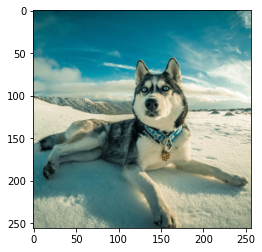

In [6]:
# Visualizing the image
plt.imshow(original_img);

**Check the size of the image**

Let's print out the shape of our variable to get more familiar with the data.

In [7]:
print("Shape of original_img is:", original_img.shape)

Shape of original_img is: (256, 256, 3)


As you can see, this creates a three-dimensional matrix `original_img` where
 
* the first two indices identify a pixel position, and
* the third index represents red, green, or blue. 

For example, `original_img[50, 33, 2]` gives the blue intensity of the pixel at row 50 and column 33.

### Processing data

Fitstly, we need to transform the matrix `original_img` into a two-dimensional matrix.

* The code below reshapes the matrix `original_img` to create an $m \times 3$ matrix of pixel colors (where
$m=65536 = 256\times256$)

In [8]:
# Reshape the image into an m x 3 matrix, where m = number of pixels
X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))

# Normalize the data
scaler = StandardScaler()
X_img = scaler.fit_transform(X_img)

# Print the first 5 rows of the reshaped and normalized data 
print(f'The first 5 rows of the reshaped and normalized data: \n{X_img[1:6,:]}')

The first 5 rows of the reshaped and normalized data: 
[[-1.3424227 -1.3824736 -1.218647 ]
 [-1.2923034 -1.3049062 -1.1503072]
 [-1.254714  -1.3049062 -1.1275272]
 [-1.2672437 -1.3242981 -1.1503072]
 [-1.3048333 -1.3436899 -1.1730871]]


### Compress the image

Run the k-means algorithm on the reshaped data.

In [9]:
# Select the parameters for KMeans
k = 16

# Assign each pixel to one of 16 clusters
km = KMeans(init='random', n_clusters=k, random_state=0)
yhat = km.fit_predict(X_img)

# Find centers of the clusters 
centers = scaler.inverse_transform(km.cluster_centers_)

Notice that we have significantly reduced the number of bits that are required to describe the image. 
  * The original image required 24 bits for each one of the $256\times256$ pixel locations, resulting in total size of $256 \times 256 \times 24 = 1,572,864$ bits. 
  * The new representation requires some additional storage for the 16 centroid colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. 
  * The final number of bits used is therefore $16 \times 24 + 256 \times 256 \times 4 = 262,528$ bits, which corresponds to compressing the original image by about a factor of 6.

In [10]:
# Assign centroids to each pixel
X_recovered = [[0,0,0] for i in range(len(yhat))]
for i in range(len(yhat)):
  X_recovered[i] = centers[yhat[i]]
X_recovered = np.array(X_recovered)

# Reshape recovered image into proper dimensions
X_recovered = np.reshape(X_recovered, original_img.shape)

Let's display the original and the compressed images.

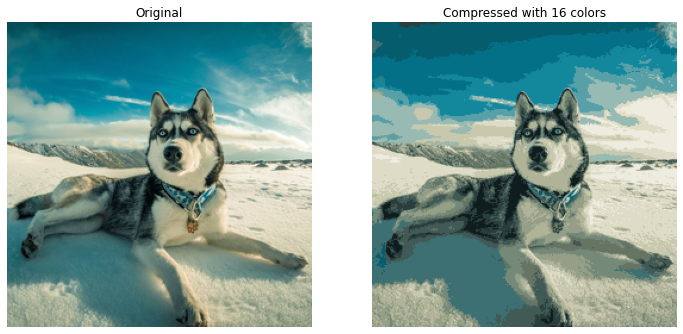

In [11]:
# Display original image
fig, ax = plt.subplots(1,2, figsize=(12,12))
plt.axis('off')

ax[0].imshow(original_img)
ax[0].set_title('Original')
ax[0].set_axis_off()

# Display compressed image
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed with 16 colors')
ax[1].set_axis_off();